In [1]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Data location
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'

# Cell types for which all compounds are available in training set
TRAIN_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types for which some compounds are available in test set
TEST_CELL_TYPES = ['Myeloid cells', 'B cells']

# Load DE data, as well as the cell type, compound and SMILES for each row
df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))
cell_types = df['cell_type']
sm_names = df['sm_name']
all_smiles = df['SMILES']

# Convert Pandas dataframe to NumPy array
for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

In [7]:
mrrmse = lambda x, y: np.mean(np.sqrt(np.mean(np.square(x - y), axis=1)))
mae = lambda x, y: np.mean(np.abs(x - y))

def sig_mrrmse(x, y):
    threshold = -np.log10(0.001)
    # threshold = -np.log10(0.01 / x.shape[1])
    weights = np.ones(x.shape)
    weights[np.abs(x) < threshold] = 0
    diff = weights * np.square(x - y)
    return np.mean(np.sqrt(np.mean(diff, axis=1)))
    

y_true = data

additive_noise = np.random.rand(*data.shape) * 6 - 3
mask = (np.abs(data) < 3)
y_pred3 = np.copy(data)
y_pred3[mask] = additive_noise[mask]

additive_noise = np.random.rand(*data.shape) * 4 - 2
mask = (np.abs(data) < 2)
y_pred2 = np.copy(data)
y_pred2[mask] = additive_noise[mask]


y_baseline = np.tile(np.mean(y_true, axis=0)[np.newaxis, :], (len(data), 1))
y_zero = np.zeros(data.shape)

print('MRRMSE')
print(mrrmse(y_true, y_pred3))
print(mrrmse(y_true, y_pred2))
print(mrrmse(y_true, y_zero))

print('Corrected MRRMSE')
print(sig_mrrmse(y_true, y_pred3))
print(sig_mrrmse(y_true, y_pred2))
print(sig_mrrmse(y_true, y_zero))

MRRMSE
1.844569133288396
1.2651529324746733
1.2814530984649364
Corrected MRRMSE
0.0
0.0
0.8486437039780549


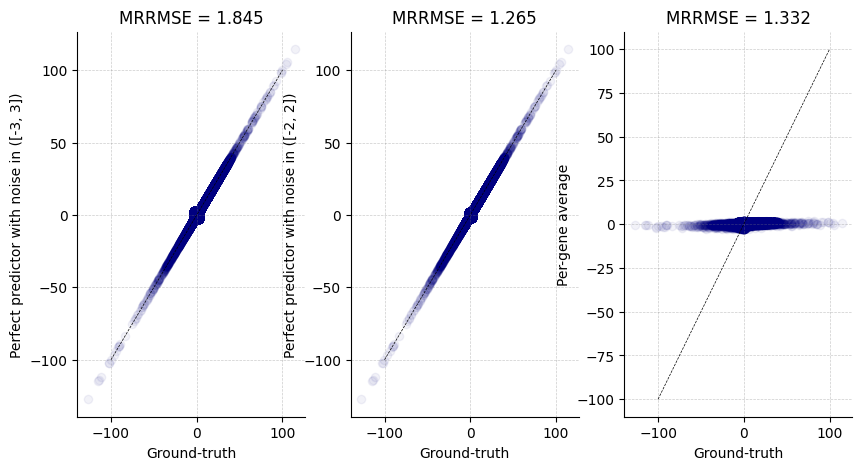

In [8]:
step = 10  # Subsetting the data points to avoid unreasonable waiting times
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 3, 1)
plt.scatter(y_true.flatten()[::step], y_pred3.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Perfect predictor with noise in ([-3, 3])')
plt.xlabel('Ground-truth')
plt.title(f'MRRMSE = {mrrmse(y_true, y_pred3):.3f}')

ax = plt.subplot(1, 3, 2)
plt.scatter(y_true.flatten()[::step], y_pred2.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Perfect predictor with noise in ([-2, 2])')
plt.xlabel('Ground-truth')
plt.title(f'MRRMSE = {mrrmse(y_true, y_pred2):.3f}')

ax = plt.subplot(1, 3, 3)
plt.scatter(y_true.flatten()[::step], y_baseline.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Per-gene average')
plt.xlabel('Ground-truth')
plt.title(f'MRRMSE = {mrrmse(y_true, y_baseline):.3f}')

#ax = plt.subplot(1, 3, 3)
#plt.scatter(y_true.flatten()[::step], y_zero.flatten()[::step], alpha=0.05, color='navy')
#plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
#plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
#ax.spines[['right', 'top']].set_visible(False)
#plt.ylabel('Baseline (zero) predictor')
#plt.xlabel('Ground-truth')
#plt.title(f'MRRMSE = {mrrmse(y_true, y_zero):.3f}')

plt.savefig('mrrmse3.png', dpi=200)
plt.show()

##### 